## Importing Libraries and Dataset

In [2]:
# data analysis
import pandas as pd
import numpy as np

# graphing
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# natural language toolkit for sentiment analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

#progress bar
from tqdm import tqdm 

The datast we'll be using for testing the natural language toolkit is "Amazon Fine Food Reviews", published by Stanford Network Analysis Project to kaggle.com, located at https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews.
This is not the dataset we will be conducting our analysis on, but rather a demonstration to show the accuracy of the sentiment analysis. By comparing our sentiment analysis scores to the scores given on the reviews, we can confirm that our analysis is accurate.

In [3]:
# dataset is cut at 3000 rows for efficiency
df = pd.read_csv('Reviews.csv')
print(df.shape)

(2999, 10)


In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Preparing Test Data

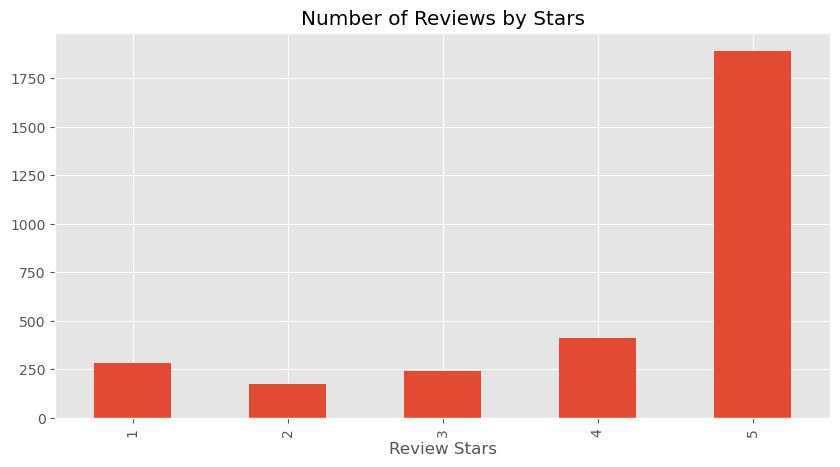

In [5]:
reviewChart = df['Score'].value_counts().sort_index().plot(kind='bar', title='Number of Reviews by Stars', figsize = (10,5))
reviewChart.set_xlabel('Review Stars')
plt.show()

In [6]:
# take a random review as an example
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
# splits the review into individual strings, or "tokens", including punctuation
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [8]:
# tags each word with a marker that marks what part of a sentence it is (noun, adjective, etc.)
tagged_tokens = nltk.pos_tag(tokens)
tagged_tokens[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [9]:
# takes a list of tagged tokens and groups them into chunks of text
entities = nltk.chunk.ne_chunk(tagged_tokens)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


Once the words are appropriately tokenized, tagged, and chunked, we can use the sentiment intensity analyzer to determine how positive or negative each review is. To do this, we will need to repeat this process for the whole dataset, then analyze these tagged chunks.

# Testing NLTK Sentiment Scoring
We will use python's NLTK, or natural language toolkit, library in order to generate numerical scores for a review's overall sentiment towards an item. This toolkit uses a bag of words approach to approximate the positive or negative sentiment of each individual word, then averages the score of all the words to find the overall scoring. Notably, this approach does not account for context between words, since it only analyzes words individually. However, it provides a decent starting point to analyze sentiment.

In [10]:
sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [12]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [13]:
# example = 'This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.'
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

After running these examples, we can conclude that the scoring for the sentiment analysis is working properly. The first example was strongly positive, and resulted in a compound score of 0.65. The second example was negative, and produced a compound score of -0.62. Therefore, we can see that the values are scored from -1 to 1, with negative scores being negative sentiments, 0 being neutral, and 1 being positive.

When we input our earlier example text from the dataset, which states "This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go", we find that we recieve a compound score of -0.54, which is reasonably negative for such a bad review. Since it appears to be working well on these examples, we will now run the sentiment analysis on the entire dataset and save the values to a dataframe.

In [48]:
# Run the polarity score on the entire dataset 
# note: this can take a while for large datasets, but the test dataset has been cut for speed
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    result[myid] = sia.polarity_scores(text)

100%|██████████| 2999/2999 [00:02<00:00, 1390.69it/s]


In [49]:
# import results into a dataframe and flip the dataframe
sentiment = pd.DataFrame(result).T
# rename index
sentiment = sentiment.reset_index().rename(columns={'index':'Id'})
# left join sentiment scores with original data
sentiment = sentiment.merge(df, how='left')

In [50]:
sentiment.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [51]:
print(sentiment.shape)

(2999, 14)


# Plot Results

Text(0.5, 1.0, 'Compound Score by Amazon Star Review')

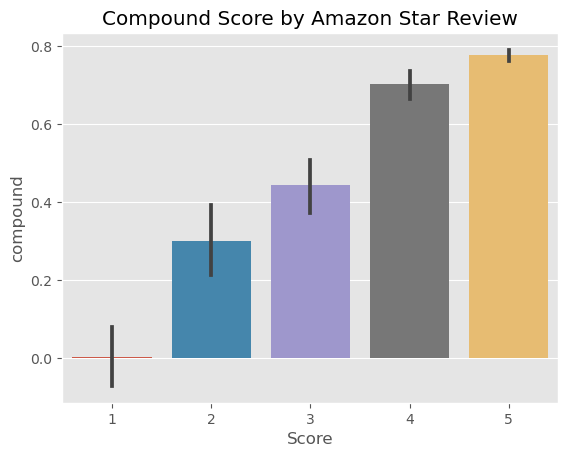

In [17]:
compound_graph = sns.barplot(data=sentiment, x='Score', y='compound')
compound_graph.set_title('Compound Score by Amazon Star Review')

The compound score is an aggregation of the positive and negative scores for a statement, providing an overall sentiment. As we can see from this plot, the compound scores seem to generally follow the number of stars a review has given a product, which is a good sign. However, we can also check the positive, negative, and neutral scores to ensure they follow the star ratings as expected.

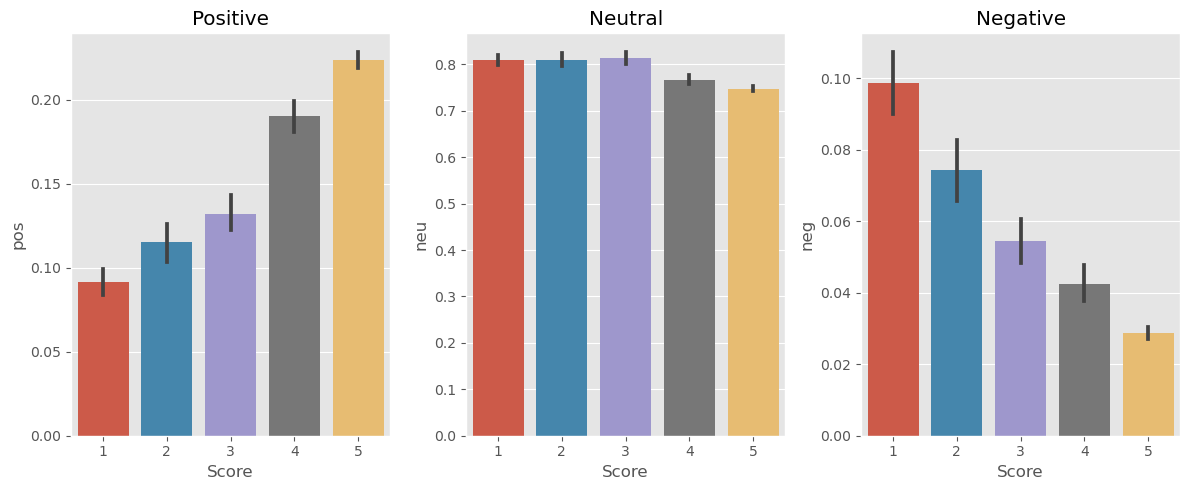

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12,5))
sns.barplot(data=sentiment, x='Score', y='pos', ax=axs[0])
sns.barplot(data=sentiment, x='Score', y='neu', ax=axs[1])
sns.barplot(data=sentiment, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

The scores generally match the number of stars, as we would expect, and so we can conclude that this sentiment analysis is reasonably accurate, despite its shortcomings.

Now that we have fully tested the sentiment of the dataset as a whole, we could choose to filter it and check the sentiments for specific criteria, such as reviews for certain items. However, since this dataset already had review scorings, that would provide little benefit over using the scores given by the writers themselves. A better use of this technology would be to run sentiment analysis on social media posts on a certain topic, such as using the social media sentiment towards a particular topic to help guide advertising decisions, which is what we will be doing. 

# Performing Sentiment Analysis on Twitter (X) Posts

Using another dataset uploaded to kaggle.com titled "Twitter Dataset - #AvengersEndgame" by Kavita Lolayekar, we can use sentiment analysis to determine the reception of a movie on X, formerly known as Twitter.

In [40]:
tweets = pd.read_csv('tweets.csv', encoding= 'unicode_escape')
print(tweets.shape)
tweets.head()

(15000, 17)


,index,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
0,1,RT @mrvelstan: literally nobody:\r\nme:\r\n\r\...,False,0,NaN,4/23/2019 10:43,False,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/android"" ...",DavidAc96,637,True,False,NaN,NaN
1,2,"RT @agntecarter: im emotional, sorry!!\r\n\r\...",False,0,NaN,4/23/2019 10:43,False,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",NRmalaa,302,True,False,NaN,NaN
2,3,saving these bingo cards for tomorrow \r\n©\r\...,False,0,NaN,4/23/2019 10:43,False,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",jijitsuu,0,False,False,NaN,NaN
3,4,RT @HelloBoon: Man these #AvengersEndgame ads ...,False,0,NaN,4/23/2019 10:43,False,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",SahapunB,23781,True,False,NaN,NaN
4,5,"RT @Marvel: We salute you, @ChrisEvans! #Capta...",False,0,NaN,4/23/2019 10:43,False,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",stella22_97,13067,True,False,NaN,NaN


result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    result[myid] = sia.polarity_scores(text)

In [41]:
len(tweets)

15000

In [46]:
# Run the polarity score on the entire dataset
# note: this can take a while
result2 = {}
for i, row in tqdm(tweets.iterrows(), total=len(tweets)):
    text = row['text']
    myid = row['index']
    result2[myid] = sia.polarity_scores(text)

100%|██████████| 15000/15000 [00:03<00:00, 4761.57it/s]


In [47]:
# import results into a dataframe and flip the dataframe
tweet_sentiment = pd.DataFrame(result2).T
# rename index
tweet_sentiment = tweet_sentiment.reset_index()

# left join sentiment scores with original data
tweet_sentiment = tweet_sentiment.merge(tweets, how='left')
tweet_sentiment.head()

,index,neg,neu,pos,compound,text,favorited,favoriteCount,replyToSN,created,...,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
0,1,0.000,1.000,0.00,0.0000,RT @mrvelstan: literally nobody:\r\nme:\r\n\r\...,False,0,NaN,4/23/2019 10:43,...,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/android"" ...",DavidAc96,637,True,False,NaN,NaN
1,2,0.113,0.697,0.19,0.2225,"RT @agntecarter: im emotional, sorry!!\r\n\r\...",False,0,NaN,4/23/2019 10:43,...,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",NRmalaa,302,True,False,NaN,NaN
2,3,0.000,1.000,0.00,0.0000,saving these bingo cards for tomorrow \r\n©\r\...,False,0,NaN,4/23/2019 10:43,...,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",jijitsuu,0,False,False,NaN,NaN
3,4,0.000,1.000,0.00,0.0000,RT @HelloBoon: Man these #AvengersEndgame ads ...,False,0,NaN,4/23/2019 10:43,...,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",SahapunB,23781,True,False,NaN,NaN
4,5,0.000,1.000,0.00,0.0000,"RT @Marvel: We salute you, @ChrisEvans! #Capta...",False,0,NaN,4/23/2019 10:43,...,NaN,1.120640e+18,NaN,"<a href=""http://twitter.com/download/iphone"" r...",stella22_97,13067,True,False,NaN,NaN


# Results of Sentiment Analysis

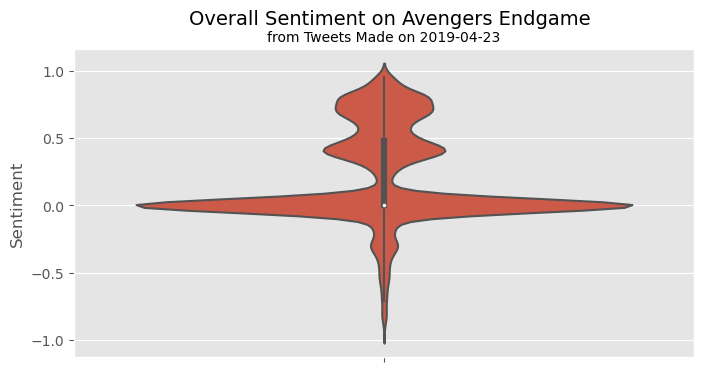

In [100]:
plt.figure(figsize=(8, 4))
sns.violinplot(data=tweet_sentiment, y='compound')
plt.suptitle('Overall Sentiment on Avengers Endgame', fontsize=14, x=0.52, y=0.98)
plt.title('from Tweets Made on 2019-04-23', fontsize=10)
plt.ylabel('Sentiment')
plt.show()

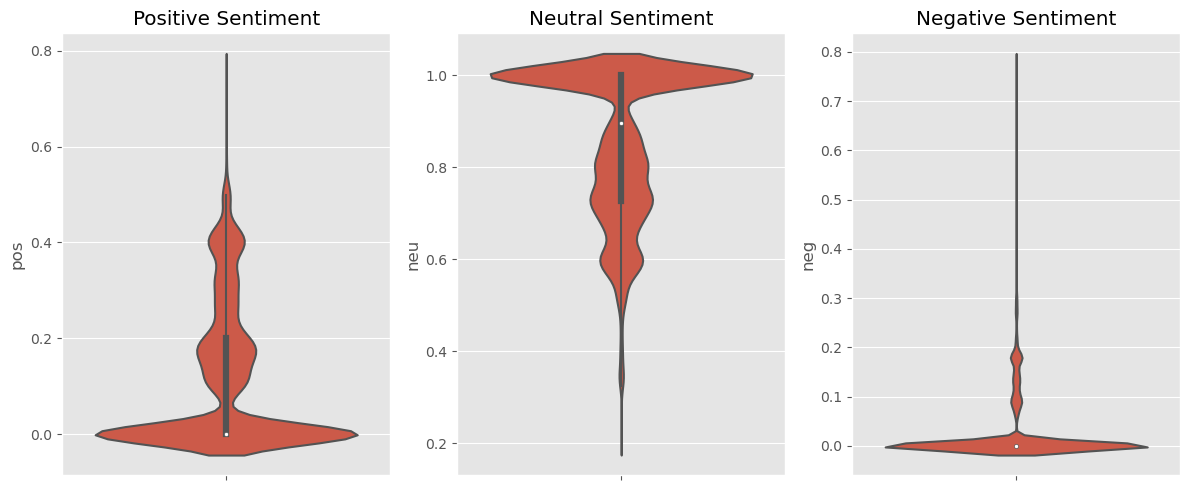

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(12,5))
sns.violinplot(data=tweet_sentiment, y='pos', ax=axs[0])
sns.violinplot(data=tweet_sentiment, y='neu', ax=axs[1])
sns.violinplot(data=tweet_sentiment, y='neg', ax=axs[2])
axs[0].set_title('Positive Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Negative Sentiment')
plt.tight_layout()
plt.show()

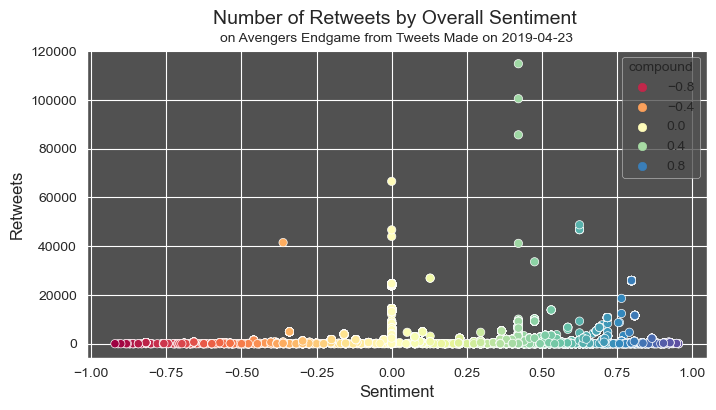

In [141]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=tweet_sentiment, y ='retweetCount', x ='compound', palette='Spectral', hue='compound')
plt.suptitle('Number of Retweets by Overall Sentiment', fontsize=14, x=0.51, y=0.98)
plt.title('on Avengers Endgame from Tweets Made on 2019-04-23', fontsize=10)
plt.ylabel('Retweets')
plt.xlabel('Sentiment')
sns.set_style(rc = {'axes.facecolor': '#515151'})
plt.show()